['225.0_69.0_0.0_2024-02-15T11 57 48.123Z.jpg', 'Tray_1_225.69.0.jpeg', 'Tray_2_628.69.0.jpeg', 'Tray_3_1018.69.0.jpeg', 'Tray_4_1415.69.0.jpeg', 'Tray_5_1815.69.0.jpeg', 'Tray_6_2204.69.0.jpeg', 'Tray_6_2204.69.0_cal.jpeg', 'Tray_7_2594.69.0.jpeg']
../data/farmbot_tray/225.0_69.0_0.0_2024-02-15T11 57 48.123Z.jpg
Tray center coordinates are valid.
Tray center coordinates:  x: 225.0 y: 69.0


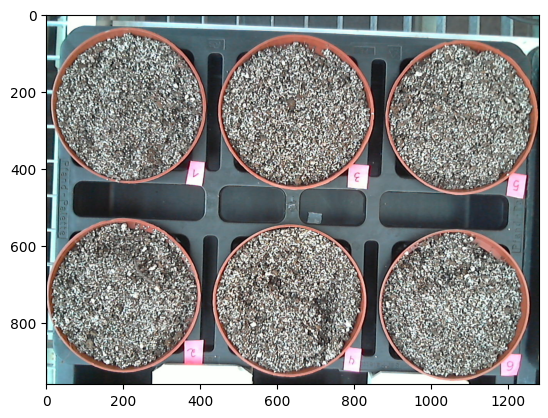

In [46]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import numpy as np
from plantcv import plantcv as pcv
import time
import math
import random

# Define constants
IMAGE_DIR = '../data/farmbot_tray/'
IMAGE_EXT = ('.jpg', '.jpeg', '.png')
IMAGE_WIDTH = 1280 # in pixels
IMAGE_HEIGHT = 960 # in pixels
TRAY_CENTER_X = 0.0 # in mm, this will be updated later
TRAY_CENTER_Y = 0.0 # in mm, this will be updated later
TRAY_CENTER_Z = 0.0 # in mm, this will be updated later
DIA_OF_POT = 60 # in mm
DIA_OF_ROI = 50 # in mm DIAMETER OF REGION OF INTEREST (ROI), should be less than DIA_OF_POT
LENGTH_TRAY_A = 155 # in mm
LENGTH_TRAY_B = 135 # in mm
ROTATION_ANGLE = -2 # in degrees
RATIO_MM2PIX = 3.2 # in pixels per mm
OFF_SET_CAM_X = 0 # in mm
OFF_SET_CAM_Y = 5 # in mm

def rotate(x, y, angle):
    x_new = int(x * np.cos(np.radians(-angle)))
    y_new = int(y * np.sin(np.radians(-angle)))
    return x_new, y_new

def de_ref(x, y, angle, x0, y0):
    a = np.tan(np.radians(angle))*y
    x_new = x0 + int((x-a)*np.cos(np.radians(angle)))
    y_new = y0 - int(y/np.cos(np.radians(angle)) + (x-a)*np.sin(np.radians(angle)))
    return x_new, y_new

def ref2img(x_ref, y_ref):
    x_img = int(x_ref + IMAGE_WIDTH/2 + OFF_SET_CAM_X*RATIO_MM2PIX)
    y_img = int(IMAGE_HEIGHT/2 - y_ref + OFF_SET_CAM_Y*RATIO_MM2PIX)
    return x_img, y_img

def img2ref(x_img, y_img):
    x_ref = int(x_img - IMAGE_WIDTH/2 - OFF_SET_CAM_X*RATIO_MM2PIX)
    y_ref = int(IMAGE_HEIGHT/2 - y_img + OFF_SET_CAM_Y*RATIO_MM2PIX)
    return x_ref, y_ref

def plt_img_show(img):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()



# Get the list of files in the directory
file_list = os.listdir(IMAGE_DIR)

# Filter out non-image files
image_files = [file for file in file_list if file.endswith(IMAGE_EXT)]

# Sort the image files alphabetically
image_files.sort()

# Read the first image file
if image_files:
    first_image_path = os.path.join(IMAGE_DIR, image_files[0])
    first_image = cv2.imread(first_image_path)
    # Do further processing with the first image
else:
    print("No image files found in the directory.")

# Print the list of image files
print(image_files)
print(first_image_path)

# Update the tray center coordinates
filenameparts = image_files[0].split('_')
TRAY_CENTER_X = float(filenameparts[0])
TRAY_CENTER_Y = float(filenameparts[1])
TRAY_CENTER_Z = float(filenameparts[2])
# check the tray center coordinates, x,y should be positive, z should be 0.0
if TRAY_CENTER_X > 0 and TRAY_CENTER_Y > 0 and TRAY_CENTER_Z == 0.0:
    print("Tray center coordinates are valid.")
    print("Tray center coordinates: ", "x:", TRAY_CENTER_X, "y:", TRAY_CENTER_Y)
else:
    print("Tray center coordinates are not valid.")

# print the first image using matplotlib
plt_img_show(first_image)

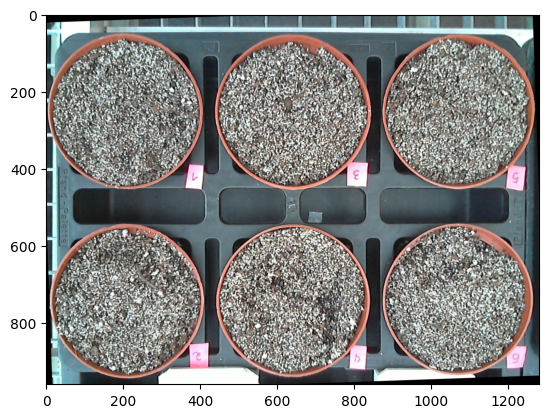

In [47]:
# Define the rotation angle
angle = -ROTATION_ANGLE

# Get the shape of the image
height, width = first_image.shape[:2]

# Calculate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

# Apply the rotation to the image
rotated_image = cv2.warpAffine(first_image, rotation_matrix, (width, height))

# Display the rotated image
plt_img_show(rotated_image)


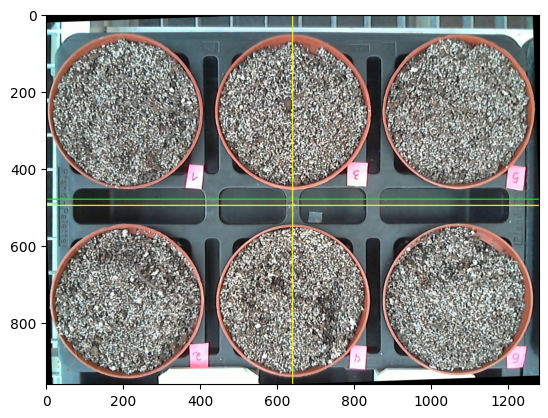

In [48]:
# Copy the first image to a control image
control_image = rotated_image.copy()

# Calculate the middle point of the image
middle_x = int(IMAGE_WIDTH / 2 + OFF_SET_CAM_X*RATIO_MM2PIX)
middle_y = int(IMAGE_HEIGHT / 2 + OFF_SET_CAM_Y*RATIO_MM2PIX)

# Draw the horizontal and vertical refference lines on the image
    # Calculate the start and end point of the horizental line based on the angle
start_x_ref = 0
start_y_ref = int(IMAGE_HEIGHT / 2)
end_x_ref = IMAGE_WIDTH
end_y_ref = int(IMAGE_HEIGHT / 2)
    # Draw the line on the image
cv2.line(control_image, (start_x_ref, start_y_ref),(end_x_ref, end_y_ref), (0, 255, 0), 2)
cv2.line(control_image, (start_x_ref, start_y_ref + int(OFF_SET_CAM_Y*RATIO_MM2PIX)), (end_x_ref, end_y_ref + int(OFF_SET_CAM_Y*RATIO_MM2PIX)), (0, 255, 255), 2)

    # Calculate the start and end point of the vertical line based on the angle
start_x_ref = int(IMAGE_WIDTH / 2)
start_y_ref = 0
end_x_ref = int(IMAGE_WIDTH / 2)
end_y_ref = IMAGE_HEIGHT
    # Draw the line on the image
cv2.line(control_image, (start_x_ref, start_y_ref),(end_x_ref, end_y_ref), (0, 255, 0), 2)
cv2.line(control_image, (start_x_ref + int(OFF_SET_CAM_X*RATIO_MM2PIX) , start_y_ref),(end_x_ref + int(OFF_SET_CAM_X*RATIO_MM2PIX), end_y_ref), (0, 255, 255), 2)
# Display the image with the line
plt_img_show(control_image)

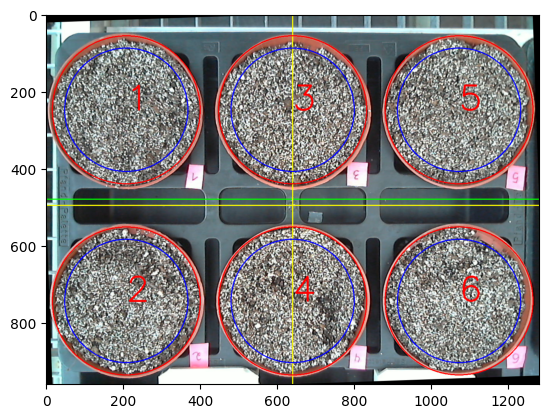

[(208, 248), (208, 744), (640, 248), (640, 744), (1072, 248), (1072, 744)]


In [49]:
# Calculate the center of the 6 pots
center_of_pots = []
    # caleculate the center of the 1. pot
        #center of the 1. pot on the reference coordinate system
center_x_1_ref = 0 - LENGTH_TRAY_B * RATIO_MM2PIX
center_y_1_ref = (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_1_img, center_y_1_img = ref2img(center_x_1_ref, center_y_1_ref)
center_of_pots.append((center_x_1_img, center_y_1_img))
cv2.circle(img=control_image, center=(center_x_1_img, center_y_1_img), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_1_img, center_y_1_img), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '1', (center_x_1_img, center_y_1_img), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 2. pot
        #center of the 2. pot on the reference coordinate system
center_x_2_ref = 0 - LENGTH_TRAY_B * RATIO_MM2PIX
center_y_2_ref = -(LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_2_img, center_y_2_img = ref2img(center_x_2_ref, center_y_2_ref)
center_of_pots.append((center_x_2_img, center_y_2_img))
cv2.circle(img=control_image, center=(center_x_2_img, center_y_2_img), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_2_img, center_y_2_img), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '2', (center_x_2_img, center_y_2_img), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 3. pot
        #center of the 3. pot on the reference coordinate system
center_x_3_ref = 0
center_y_3_ref = (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_3_img, center_y_3_img = ref2img(center_x_3_ref, center_y_3_ref)
center_of_pots.append((center_x_3_img, center_y_3_img))
cv2.circle(img=control_image, center=(center_x_3_img, center_y_3_img), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_3_img, center_y_3_img), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '3', (center_x_3_img, center_y_3_img), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 4. pot
        #center of the 4. pot on the reference coordinate system
center_x_4_ref = 0
center_y_4_ref = -(LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_4_img, center_y_4_img = ref2img(center_x_4_ref, center_y_4_ref)
center_of_pots.append((center_x_4_img, center_y_4_img))
cv2.circle(img=control_image, center=(center_x_4_img, center_y_4_img), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_4_img, center_y_4_img), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '4', (center_x_4_img, center_y_4_img), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 5. pot
        #center of the 5. pot on the reference coordinate system
center_x_5_ref = 0 + LENGTH_TRAY_B * RATIO_MM2PIX
center_y_5_ref = (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_5_img, center_y_5_img = ref2img(center_x_5_ref, center_y_5_ref)
center_of_pots.append((center_x_5_img, center_y_5_img))
cv2.circle(img=control_image, center=(center_x_5_img, center_y_5_img), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_5_img, center_y_5_img), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '5', (center_x_5_img, center_y_5_img), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 6. pot
        #center of the 6. pot on the reference coordinate system
center_x_6_ref = 0 + LENGTH_TRAY_B * RATIO_MM2PIX
center_y_6_ref = - (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_6_img, center_y_6_img = ref2img(center_x_6_ref, center_y_6_ref)
center_of_pots.append((center_x_6_img, center_y_6_img))
cv2.circle(img=control_image, center=(center_x_6_img, center_y_6_img), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_6_img, center_y_6_img), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '6', (center_x_6_img, center_y_6_img), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)

# Display the image with the line
plt_img_show(control_image)
print(center_of_pots)

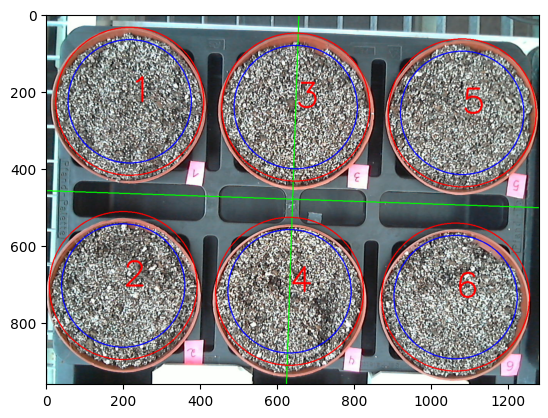

In [22]:
# Copy the first image to a control image
control_image = first_image.copy()

# Calculate the middle point of the image
middle_x = int(IMAGE_WIDTH / 2 + OFF_SET_CAM_X*RATIO_MM2PIX)
middle_y = int(IMAGE_HEIGHT / 2 + OFF_SET_CAM_Y*RATIO_MM2PIX)

# Draw the horizontal and vertical refference lines on the image
    # Calculate the start and end point of the horizental line based on the angle
line_length = int(IMAGE_WIDTH/2) # Adjust the length of the line as needed
start_x_ref = -int(line_length)
start_y_ref = int(0)
end_x_ref = int(line_length)
end_y_ref = int(0)
    # Draw the line on the image
cv2.line(control_image, de_ref(start_x_ref, start_y_ref,ROTATION_ANGLE,middle_x,middle_y),
         de_ref(end_x_ref, end_y_ref,ROTATION_ANGLE,middle_x,middle_y), (0, 255, 0), 2)

    # Calculate the start and end point of the vertical line based on the angle
line_length = int(IMAGE_HEIGHT/2) # Adjust the length of the line as needed
start_x_ref = int(0)
start_y_ref = int(line_length)
end_x_ref = int(0)
end_y_ref = -int(line_length)
    # Draw the line on the image
cv2.line(control_image, de_ref(start_x_ref, start_y_ref,ROTATION_ANGLE,middle_x,middle_y),
         de_ref(end_x_ref, end_y_ref,ROTATION_ANGLE,middle_x,middle_y), (0, 255, 0), 2)


# Calculate the center of the 6 pots
center_of_pots = []
    # caleculate the center of the 1. pot
        #center of the 1. pot on the reference coordinate system
center_x_1_ref = 0 - LENGTH_TRAY_B * RATIO_MM2PIX
center_y_1_ref = (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_1, center_y_1 = de_ref(center_x_1_ref, center_y_1_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_1, center_y_1))
cv2.circle(img=control_image, center=(center_x_1, center_y_1), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_1, center_y_1), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '1', (center_x_1, center_y_1), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 2. pot
        #center of the 2. pot on the reference coordinate system
center_x_2_ref = 0 - LENGTH_TRAY_B * RATIO_MM2PIX
center_y_2_ref = -(LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_2, center_y_2 = de_ref(center_x_2_ref, center_y_2_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_2, center_y_2))
cv2.circle(img=control_image, center=(center_x_2, center_y_2), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_2, center_y_2), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '2', (center_x_2, center_y_2), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 3. pot
        #center of the 3. pot on the reference coordinate system
center_x_3_ref = 0
center_y_3_ref = (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_3, center_y_3 = de_ref(center_x_3_ref, center_y_3_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_3, center_y_3))
cv2.circle(img=control_image, center=(center_x_3, center_y_3), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_3, center_y_3), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '3', (center_x_3, center_y_3), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 4. pot
        #center of the 4. pot on the reference coordinate system
center_x_4_ref = 0
center_y_4_ref = -(LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_4, center_y_4 = de_ref(center_x_4_ref, center_y_4_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_4, center_y_4))
cv2.circle(img=control_image, center=(center_x_4, center_y_4), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_4, center_y_4), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '4', (center_x_4, center_y_4), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 5. pot
        #center of the 5. pot on the reference coordinate system
center_x_5_ref = 0 + LENGTH_TRAY_B * RATIO_MM2PIX
center_y_5_ref = (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_5, center_y_5 = de_ref(center_x_5_ref, center_y_5_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_5, center_y_5))
cv2.circle(img=control_image, center=(center_x_5, center_y_5), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_5, center_y_5), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '5', (center_x_5, center_y_5), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 6. pot
        #center of the 6. pot on the reference coordinate system
center_x_6_ref = 0 + LENGTH_TRAY_B * RATIO_MM2PIX
center_y_6_ref = - (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_6, center_y_6 = de_ref(center_x_6_ref, center_y_6_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_6, center_y_6))
cv2.circle(img=control_image, center=(center_x_6, center_y_6), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_6, center_y_6), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '6', (center_x_6, center_y_6), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)

# Display the image with the line
plt_img_show(control_image)

208 256
208 736
640 256
640 736
1072 256
1072 736


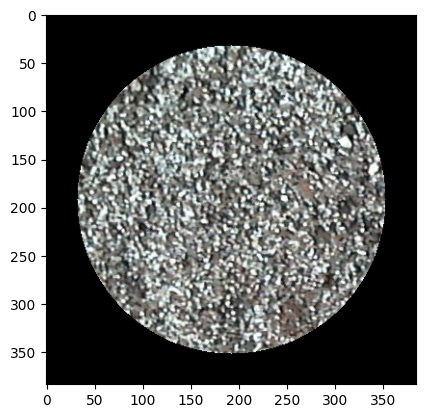

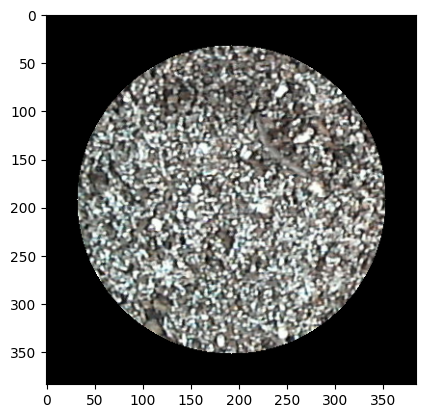

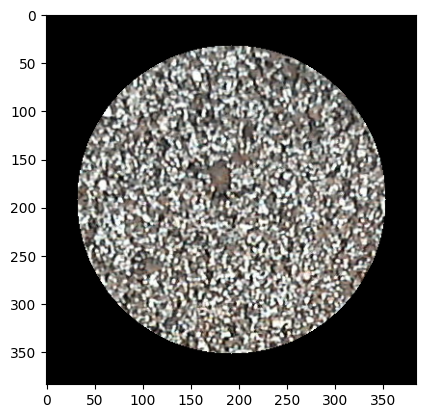

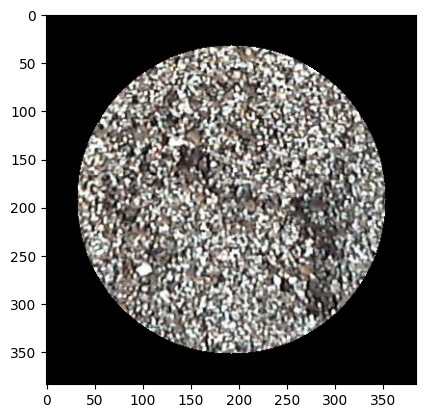

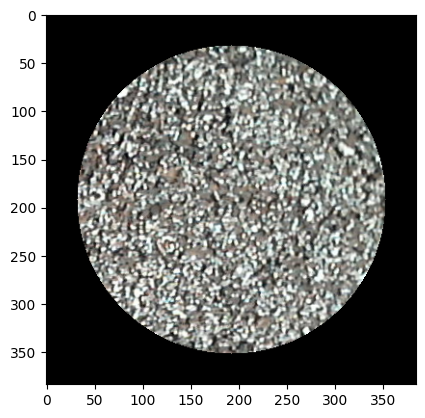

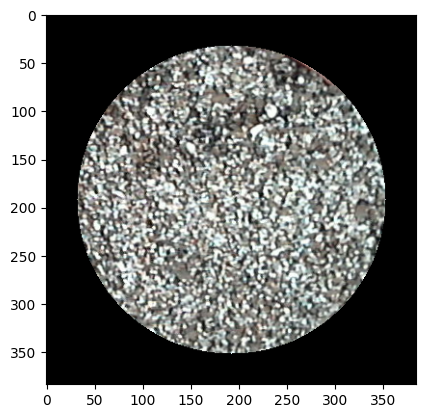

In [45]:
def pick_roi_area(center_x, center_y, image):
    # Calculate the coordinates of the top-left and bottom-right corners of the ROI
    roi_x1 = int(center_x - DIA_OF_POT * RATIO_MM2PIX)
    roi_y1 = int(center_y - DIA_OF_POT * RATIO_MM2PIX)
    roi_x2 = int(center_x + DIA_OF_POT * RATIO_MM2PIX)
    roi_y2 = int(center_y + DIA_OF_POT * RATIO_MM2PIX)

    # Crop the ROI from the image
    roi = image[roi_y1:roi_y2, roi_x1:roi_x2]

    # Set pixels outside of the ROI circle to black
    mask = np.zeros_like(roi)
    radius = int(DIA_OF_ROI * RATIO_MM2PIX)
    center = (roi.shape[1] // 2, roi.shape[0] // 2)  # Set center as the middle of the ROI
    cv2.circle(mask, center, radius, (255, 255, 255), -1)
    roi = cv2.bitwise_and(roi, mask)

    # Return the ROI
    return roi

# Calculate the area of the ROI for each pot
roi_areas = []
for center_x, center_y in center_of_pots:
    print(center_x, center_y)
    roi_area = pick_roi_area(center_x, center_y, rotated_image)
    roi_areas.append(roi_area)

# Display the areas of the ROIs using plt_img_show
for img in roi_areas:
    plt_img_show(img)

############################# START #############################
processing image:
	 total 2 region(s) found!


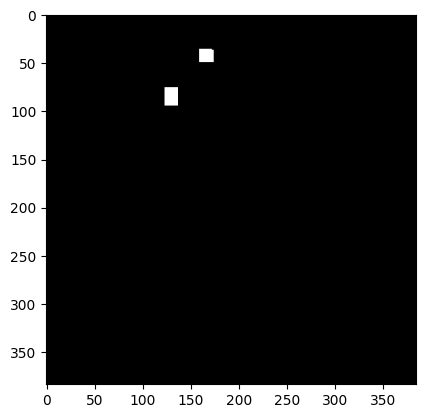

	 prossible watering point: (232, 250)
	 prossible watering point: (109, 117)
	 prossible watering point: (218, 228)
	 prossible watering point: (151, 238)
	 prossible watering point: (132, 230)
	 prossible watering point: (115, 154)
	 prossible watering point: (201, 152)
	 prossible watering point: (342, 173)
	 prossible watering point: (138, 162)
	 prossible watering point: (291, 302)
	 prossible watering point: (165, 155)
	 prossible watering point: (151, 344)
	 prossible watering point: (222, 234)
	 prossible watering point: (245, 244)
	 prossible watering point: (187, 196)
	 prossible watering point: (146, 137)
	 prossible watering point: (217, 220)
	 prossible watering point: (171, 195)
	 prossible watering point: (216, 147)
	 prossible watering point: (159, 128)
	 prossible watering point: (283, 87)
	 prossible watering point: (272, 210)
	 prossible watering point: (337, 168)
	 prossible watering point: (177, 268)
	 prossible watering point: (39, 227)
	 prossible watering point:

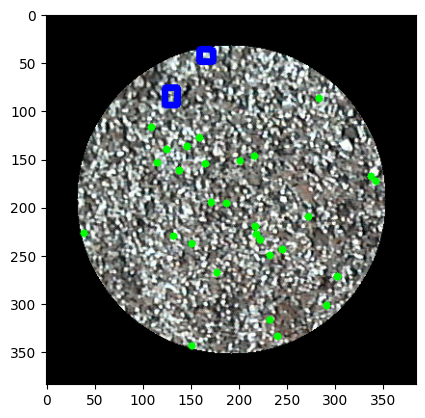

	 Execution time: 0.31 seconds
############################# END #############################




[(232, 250),
 (109, 117),
 (218, 228),
 (151, 238),
 (132, 230),
 (115, 154),
 (201, 152),
 (342, 173),
 (138, 162),
 (291, 302),
 (165, 155),
 (151, 344),
 (222, 234),
 (245, 244),
 (187, 196),
 (146, 137),
 (217, 220),
 (171, 195),
 (216, 147),
 (159, 128),
 (283, 87),
 (272, 210),
 (337, 168),
 (177, 268),
 (39, 227),
 (232, 317),
 (240, 334),
 (302, 272),
 (125, 140)]

In [5]:
#run all the test images at ones

def calculate_watering_points(img):
    pcv.params.debug="none"
    # Define the pot center and radius
    pot_x = int(img.shape[1] / 2)
    pot_y = int(img.shape[0] / 2)
    roi_radius = int(DIA_OF_ROI * RATIO_MM2PIX)
    # Set a timer for the execution time
    start_time = time.time()
    print('############################# START #############################')
    print('processing image:')
    # mask in H channel (this is a way to write in opencv, but we will use plantcv for this task)
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_H = img_HSV[:, :, 0]
    img_H_thresh = cv2.inRange(img_H, 20, 40)
    # mask in A channel
    img_A=pcv.rgb2gray_lab(rgb_img=img, channel="A")
    img_A_hist_EQU=pcv.hist_equalization(img_A)
    img_A_thresh, __ = pcv.threshold.custom_range(img=img_A_hist_EQU, lower_thresh=[0], upper_thresh=[30], channel='gray')
    # mask in V channel
    img_V=pcv.rgb2gray_hsv(rgb_img=img, channel="V")
    img_V_thresh_up = pcv.threshold.binary(gray_img=img_V, threshold = 250, object_type='dark')
    img_V_thresh_down = pcv.threshold.binary(gray_img=img_V, threshold = 50, object_type='light')
    img_V_thresh = cv2.bitwise_and(img_V_thresh_up,img_V_thresh_down)
    # combine H A V masks
    img_H_thresh_erode = pcv.erode(gray_img = img_H_thresh, ksize = 5, i = 1)
    img_A_thresh_erode = pcv.erode(gray_img = img_A_thresh, ksize = 5, i = 1)
    img_thresh = cv2.bitwise_or(img_A_thresh_erode,img_H_thresh_erode)
    img_thresh = cv2.bitwise_and(img_thresh,img_V_thresh)
    # closing method to the mask
    mask_dilated = pcv.dilate(gray_img = img_thresh, ksize = 5, i = 2)
    mask_erode = pcv.erode(gray_img = mask_dilated, ksize = 5, i =3)
    mask_dilated = pcv.dilate(gray_img = mask_erode, ksize = 5, i = 3)
    mask = mask_dilated

    # labeled the regions on the mask image
    labeled_mask, num_mask = pcv.create_labels(mask=mask)
    #pcv.plot_image(labeled_mask)
    print('{}'.format('\t'),'total', num_mask, 'region(s) found!')

    # just keep the first 10 biggst region on the mask
    count = 0
    region_info={}
    for region_id in range(1,num_mask+1,1):
        mask_region_cnt = cv2.inRange(labeled_mask,region_id,region_id)
        count = cv2.countNonZero(mask_region_cnt)
        region_info[region_id]= (region_id, count)
    list_of_region = list(region_info.values())
    sorted_data = sorted(list_of_region, key=lambda x: x[1], reverse=True)
    sorted_data_cop = sorted_data[:10]

    mask_cop = np.zeros(np.shape(mask),dtype=np.uint8)
    for region_id in sorted_data_cop:
        id = (int)(region_id[0])
        mask_cop+=cv2.inRange(labeled_mask,id,id)

    pcv.plot_image(mask_cop)


    # calculation the center of mass of the region
    # this will locate the plant
    contours, hierarchy = cv2.findContours(mask_cop,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
##    cnt = contours[0]
##    M = cv.moments(cnt)
##    cx = int(M['m10']/M['m00'])
##    cy = int(M['m01']/M['m00'])
##    print('{}'.format('\t'),'location of the plant(x,y):',cx,cy)
    mask_RGB=cv2.cvtColor(mask_cop,cv2.COLOR_GRAY2BGR)
    
    # let us define the watering point.
    num_watering_points = 4*7 # 4 time a day and 7 days a week
    # create watering point
    #angel = 30 # must be 15, 30, 45, 60, 90
    # the previous mask will be enlarged, so that there will be a safty zone, that we will not water the leaves
    mask_with_saftyzone = pcv.dilate(gray_img = mask_cop, ksize = 15, i = 3)
    watering_points_list = []
    count = 0
    while (count<=num_watering_points):
        angel = random.randint(0,360)
        rel_radius = random.random()
        x_watering_point = (int)(math.cos(angel/180*math.pi)*(roi_radius)*rel_radius+pot_x)
        y_watering_point = (int)(math.sin(angel/180*math.pi)*(roi_radius)*rel_radius+pot_y)
        if mask_with_saftyzone[y_watering_point, x_watering_point] != 255:
            watering_points_list.append((x_watering_point, y_watering_point))
            count+=1
        #watering_point_list.append((x_watering_point, y_watering_point))
            
    # lets draw everything on image
    img_out = img.copy()
    for i in watering_points_list:
        cv2.circle(img_out,i,4,(0,255,0),-1) # -1 means fill the circle
        print('{}'.format('\t'),'prossible watering point:',i)
    cv2.drawContours(img_out, contours, contourIdx=-1, color=(255,0,0), thickness=5)
    plt_img_show(img_out)
    
    
    end_time = time.time()
    print('{}'.format('\t'),'Execution time:', round(end_time - start_time, 2), 'seconds')
    print('############################# END #############################')
    print('{}'.format('\n'))
    #endfor
    return watering_points_list

calculate_watering_points(roi_areas[0])